In [1]:
from EDA.visualization import *
from EDA.folium import *
from Modeling.similarity import *
from Modeling.clustering import *
import sys
sys.path.append('./EDA')
sys.path.append('./Modeling')
sys.path.append('./Data/csv')


# 0. 데이터 설명 
### 1) 버스정류장별 일별 시간별 승하차 승객수 데이터    
버스정류장별로 매일 시간당 승하차 승객수가 몇명인지 나타나 있는 데이터    
### 2) 버스정류장별 주변 인프라 데이터       
약 12000개의 버스정류장 별로 주변 인프라가 어떤 것이 있고, 몇개가 있는지 나타나 있는 데이터  

---

# 1. Feature Engineering


## 1-1. feature 가공 전 상관관계 확인 
버스 정류장별 주변 인프라 데이터에서 종속인 컬럼들을 확인

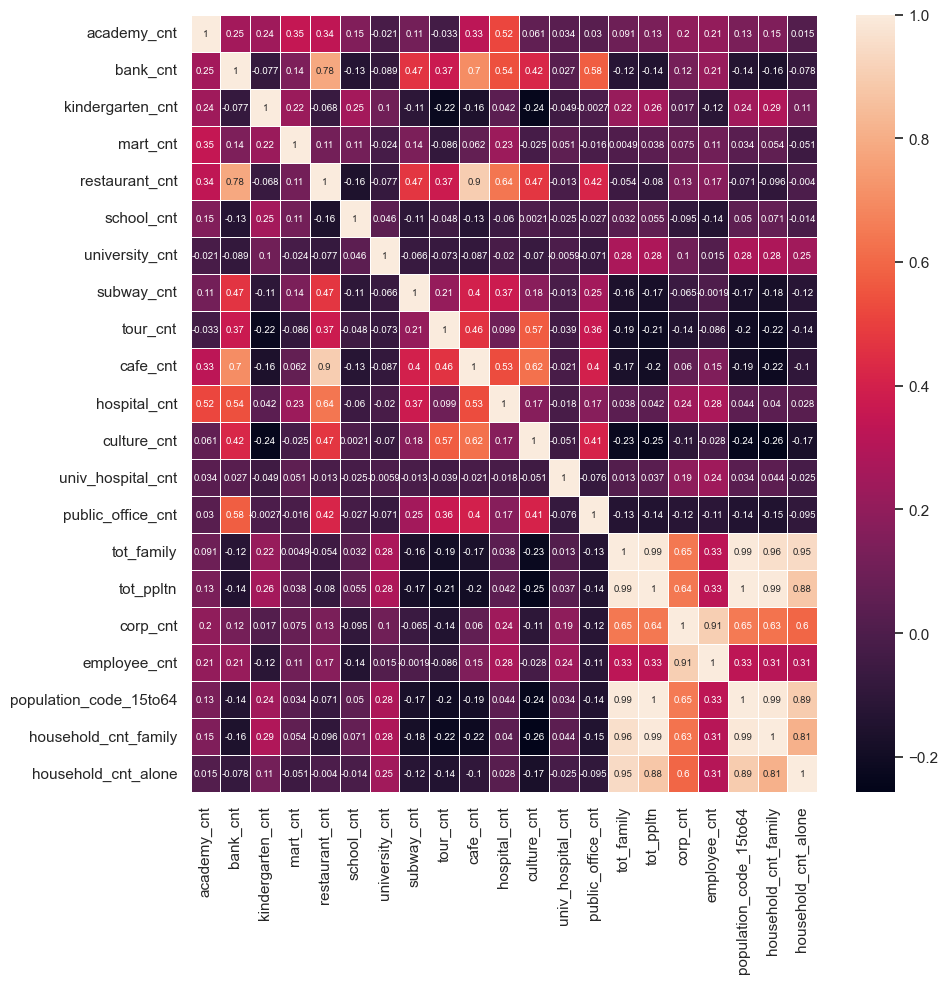

In [2]:
df_check1, df_check2 =get_heatmap_data()
get_heatmap(df_check1)

- 변수 간 상관관계 분석을 위해 heatmap 생성.  
- <u>통계 데이터</u>끼리 높은 상관관계를 보이는 경향 발견.
  - 통계 데이터: tot_family(총 가구수), tot_ppltn(총 인구수), corp_cnt(사업체 수), employee_cnt(종사자 수) 등등
- 통계 데이터는 인구, 사업체 관련 지역별 특징 추출을 위해 반드시 필요하므로 Feature Extraction을 통해 <u>특성을 조합</u>하여 상관관계를 낮춰보고자 함.

 ## 1-2. Feature Extraction 진행
 <!-- <img src="./Data/img/EDA1_상관관계표2.png">   -->


![Alt Text](https://raw.githubusercontent.com/Mulcam-Finalproject3/Resurrection_Of_Squirrel_Bus/a27685169612e8c5111346e7212e4ceed0d40f37/src/Data/img/EDA1_%EC%83%81%EA%B4%80%EA%B4%80%EA%B3%84%ED%91%9C2.png?token=GHSAT0AAAAAACDTSDP2PUUV2WCQ5OP7TWQ4ZIALBUQ)

 
 - `alone_ratio`
   - 식: household_cnt_alone(1인가구 수) / tot_family(총 가구 수)
   - 의미: 총 가구 수 대비 1인 가구 수 비율
 - `corp_emp_ratio`
   - 식: corp_cnt(사업체 수)/employee_cnt(종사자 수)
   - 의미: 한 사업체 당 종사자 수. 사업체 규모  
- 기존의 feature & Extracted feature와 중복된 의미를 지닌 feature → 제외
  - tot_ppltn (총 인구 수)
  - household_cnt_family (친족가구 수)


## 1-3. Feature Selection 진행
- alone_ratio, corp_emp_ratio 산출에 쓰였던 컬럼 중 타 변수들과 상관관계가 높은 변수들 제외.
    - household_cnt_alone, tot_ppltn, corp_cnt
- 그 후, heatmap 통해 상관관계 재확인.

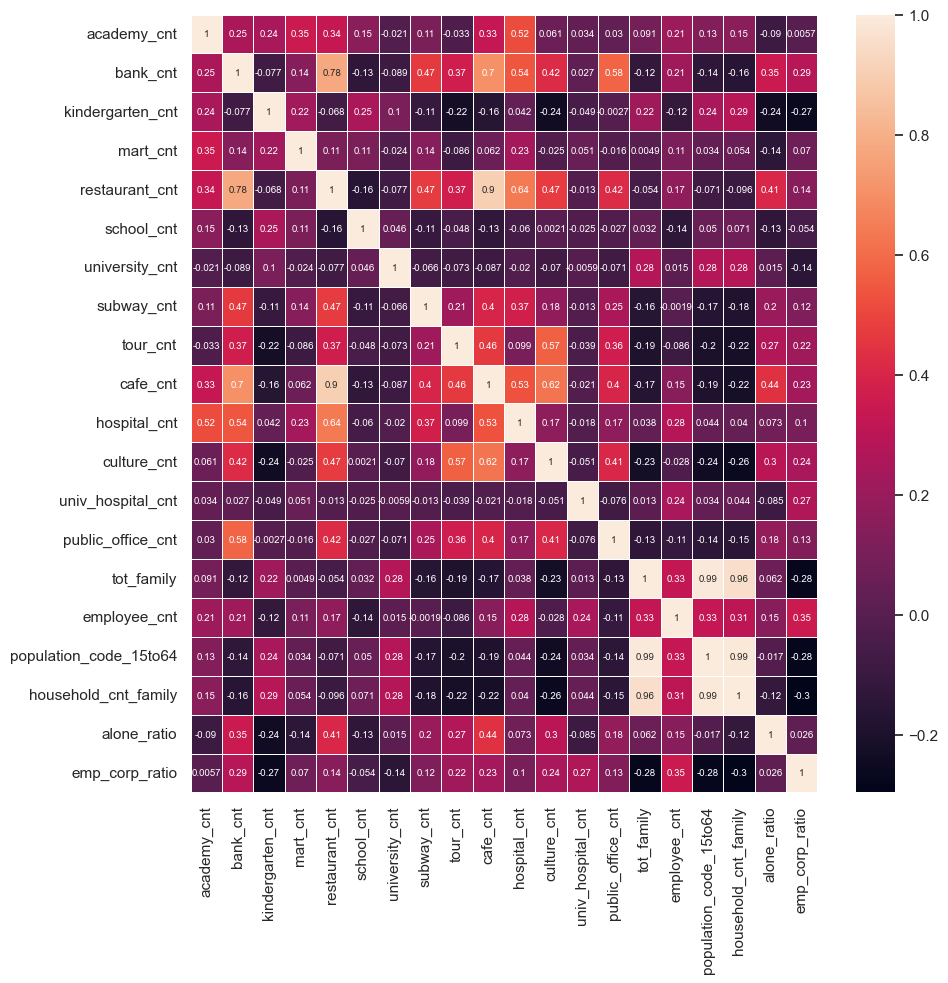

In [3]:
df = tb_infra_population
df['alone_ratio'] = df['household_cnt_alone']/df['tot_ppltn'] 
df['emp_corp_ratio'] = df['employee_cnt']/df['corp_cnt']

drop_col = ['household_cnt_alone','tot_ppltn','corp_cnt']
df = df.drop(drop_col,axis=1)

heatmap_col = ['academy_cnt', 'bank_cnt', 'kindergarten_cnt', 'mart_cnt',
       'restaurant_cnt', 'school_cnt', 'university_cnt', 'subway_cnt',
       'tour_cnt', 'cafe_cnt', 'hospital_cnt', 'culture_cnt',
       'univ_hospital_cnt', 'public_office_cnt', 'tot_family', 'employee_cnt',
       'population_code_15to64', 'household_cnt_family', 'alone_ratio',
       'emp_corp_ratio']
       
get_heatmap(df[heatmap_col])

- 잔존 변수 중, population_code_15to64(경제인구 수)는 지역별 특징 확인에 반드시 필요하다 생각.
- 따라서 <u>population_code_15to64와 상관관계가 높은 변수들</u> 제외.
<br></br>
  - tot_family, household_cnt_family
  - ![image1](https://github.com/Mulcam-Finalproject3/Resurrection_Of_Squirrel_Bus/blob/master/src/Data/img/EDA1_%EC%83%81%EA%B4%80%EA%B4%80%EA%B3%84%ED%91%9C2.png?raw=true)

## 1-4. 최종 feature들의 상관관계 확인

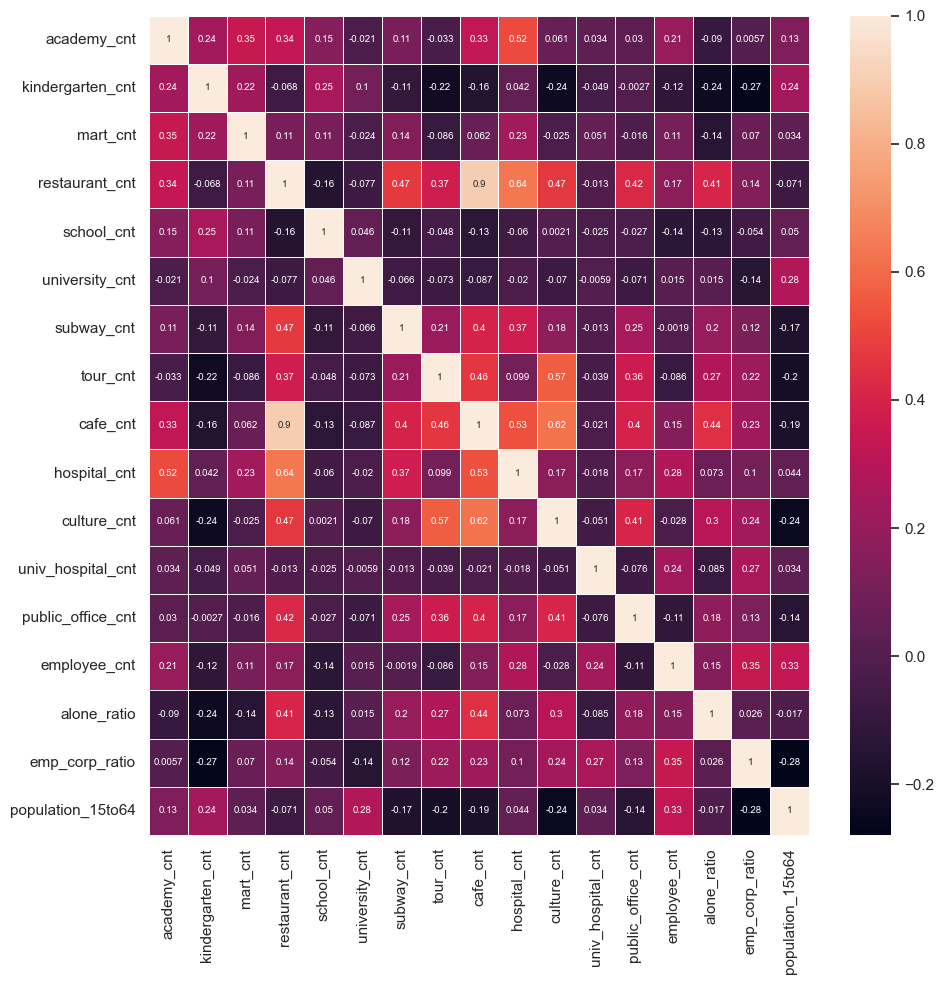

In [4]:
get_heatmap(df_check2)

> #### <b><분석 1 결과></b>  
> feature 가공을 통해 대부분의 feature들의 상관관계를 0.7 미만으로 조정

---

# 2. 다람쥐 버스 정류장은 어느 구에 위치해 있는가?

In [5]:
df_daram = get_daram_95station_df()
df_daram_gu = df_daram.groupby('법정동_구').count()[['NODE_ID']]
df_daram_gu = df_daram_gu.sort_values(by='NODE_ID',ascending=False)

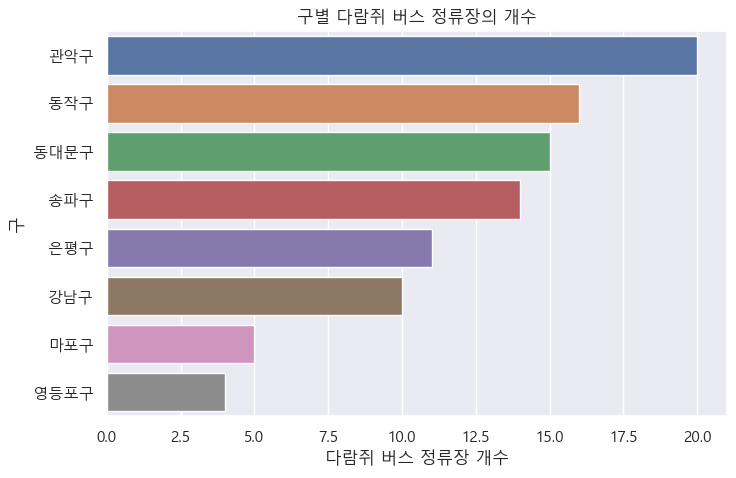

In [6]:
get_normal_barplot('NODE_ID',df_daram_gu.index, df_daram_gu,'다람쥐 버스 정류장 개수','구','구별 다람쥐 버스 정류장의 개수')

In [7]:
df_ride_alight_gu = final_tb_infra_population.groupby(['법정동_구']).sum()[['RIDE_SUM_6_10','ALIGHT_SUM_6_10']]
df_ride_alight_gu = df_ride_alight_gu.sort_values(by='RIDE_SUM_6_10',ascending=False)

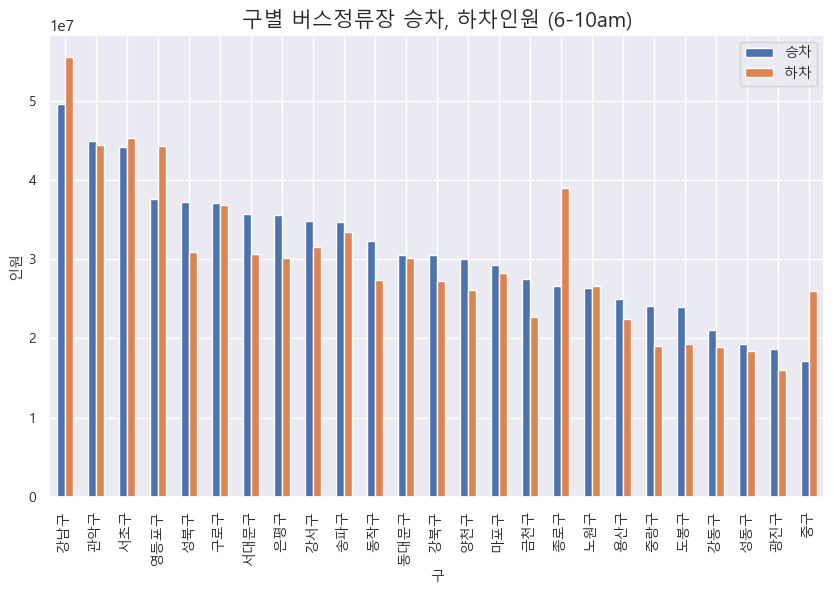

In [8]:
df_ride_alight_gu[['RIDE_SUM_6_10','ALIGHT_SUM_6_10']].plot.bar(figsize=(10,6))
plt.title('구별 버스정류장 승차, 하차인원 (6-10am)',fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.xlabel('구', fontdict={'fontsize': 10})
plt.ylabel('인원', fontdict={'fontsize': 10})
plt.legend(['승차','하차'],fontsize=10)
plt.show()

>#### <b><분석2 결론></b>
> - 버스정류장이 많은 구가 승하차 승객수가 반드시 비례하지 않음을 알 수 있다.
> - 위의 두 그래프를 비교해봤을 때, 다람쥐버스 정류장이 반드시 버스 승/하차 인원 수가 많은 순으로 설치되는 것은 아니라는 점을 알 수 있다.
> - 즉, 버스 승/하차 인원수 외에 기타 요소들(인프라, 인구특성 등)이 버스 정류장 선정에 작용했을 것이라 추측.
> - 그러므로 기존 다람쥐 버스 정류장의 인프라, 인구특성을 파악하고, 이와 유사한 특성을 지닌 정류장을 새로운 다람쥐 버스 정류장으로 선정해야할 필요가 있다.
<br></br>

> - <u>신설될 다람쥐 버스의 정류장은 기존 다람쥐 버스 정류장과는 다른 `새로운 구`이며 기존 다람쥐 버스 정류장과 `유사한 인프라, 인구 특성`을 지닐 것.</u>
> - <u>`유사도`를 이용하여 기존 다람쥐 버스 정류장과 유사한 정류장을 탐색해야 한다.</u>
<b>


---

# 3. 다람쥐 버스 vs 일반 버스의 정류장 특징 비교

- ##### <b>🚩목적: 일반 버스 정류장과 다람쥐 버스 정류장을 비교하여, 다람쥐 버스 정류장이 다른 일반버스 정류장보다 두드러지게 갖고 있는 인프라, 인구 특성을 파악할 것.</b>
- 아래 두가지 타입의 정류장들의 평균적인 인프라, 인구 특징을 비교
  - 다람쥐 버스: 다람쥐 버스의 정류장(95개) 중 승/하차가 각각 많은 정류장 top 30개의 평균적인 인프라, 인구 수
  - 전체 버스: 일반 버스 정류장 (약 12,000개)의 평균적인 인프라, 인구 수

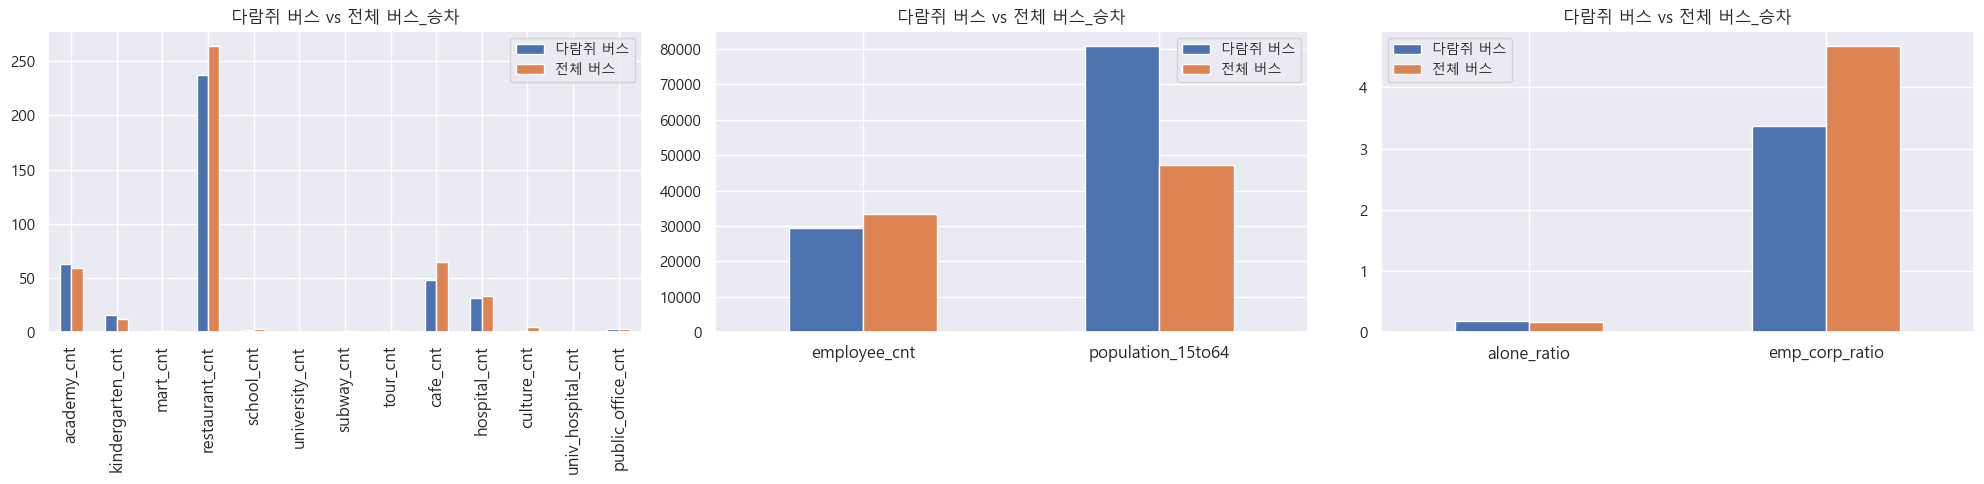

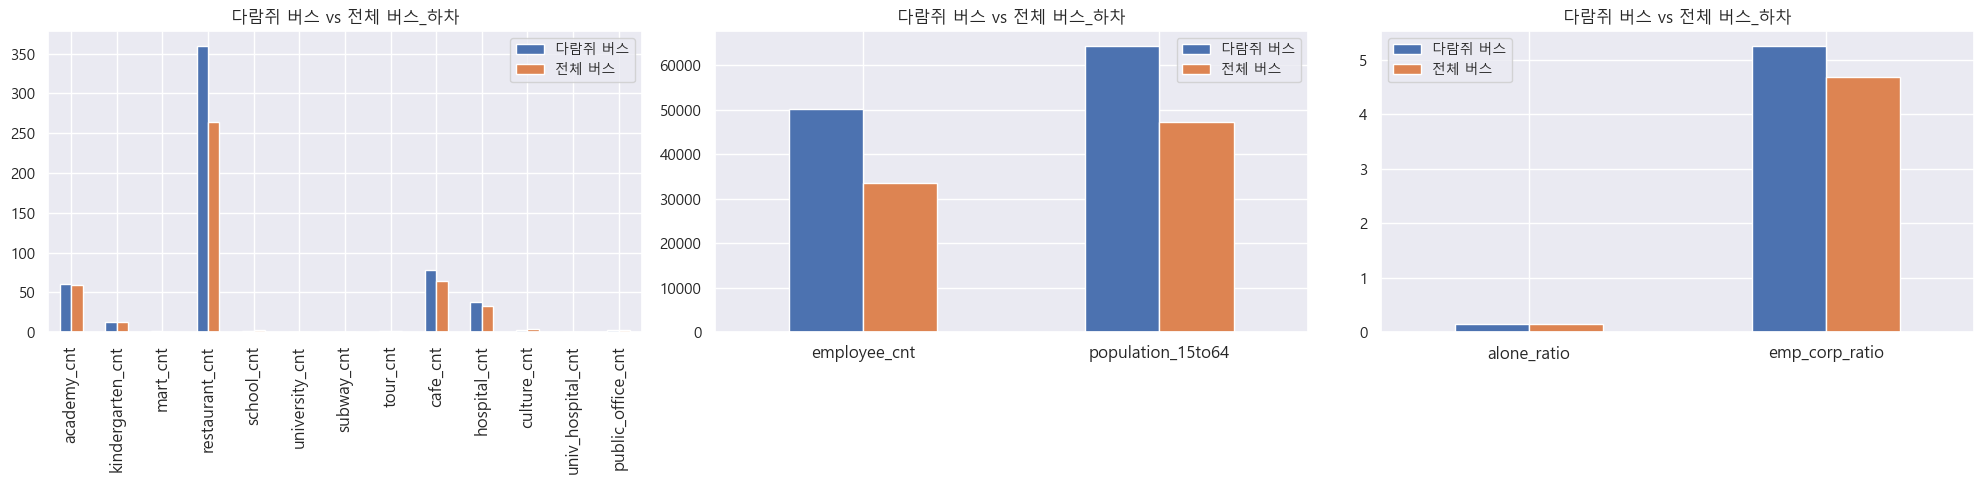

In [9]:
get_barplot_daram_vs_all()

> #### <b><분석 3 결론></b>
> **1. 다람쥐 버스의 승차가 많은 지역의 특징**
>   - 인프라 특징: 학원, 유치원↑
>   - 인구 특징: 15-64 경제인구 수 ↑
>   - 종합: 거주지의 특징을 보임

>**2. 다람쥐 버스의 하차가 많은 지역의 특징**
>   - 인프라 특징: 학원, 유치원, 병원, 식당, 카페↑
>   - 인구 특징: 15-64 경제인구 수, 사업체 별 종사자 수, 종사자 수
>   - 종합: 다양한 특징이 혼재

> **3. 결론**
>   - 승차, 하차가 각각 많은 지역만의 두드러진 특징을 추출할 수 <u><b>없었다</b></u>.  
>       - 원인: 다람쥐 버스를 신설하려면 기점과 종점을 어느위치에 할 것인가가 중요한데, 상위 30개의 다람쥐 버스 정류장들은 <u><b>기,종점 + 경유지를 분석한 것이기 때문에 다람쥐 버스만의 특징이 잘 나타나지 않음</b></u>. 
>   - 특징이 두드러지게 드러날 수 있도록 하는 분석이 필요하다.
>   - 다람쥐 버스의 특징이 뚜렷하게 보이는 정류장 = 다람쥐 버스의 기점, 종점 
>   - ⭐추후 분석 방향: 다람쥐 버스의 기점, 종점만의 특징을 분석

---

# 4. 다람쥐 버스의 기점, 종점 분석

In [10]:
tb_subway_month_addr = pd.read_csv(os.path.join(csv_path,'tb_subway_month_addr.csv'))
df_filtered = df_preprocess(tb_subway_month_addr)

## 4-1. "다람쥐 버스의 기점, 종점 - 승/하차 수 Top 30인 지하철 역" 과의 연관성
- 버스 이외 주로 사용되는 대중교통인 지하철의 유동인구를 분석하여 다람쥐 버스와의 연관성을 파악하고자 분석을 진행.

### 1) 승차

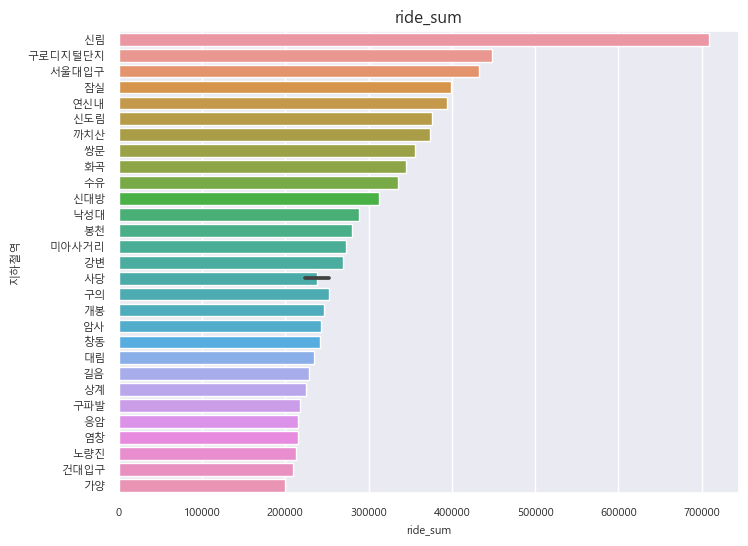

In [11]:
get_subway_barplot(df_filtered, 'ride_sum','지하철역', 'ride_sum')

### 2) 하차

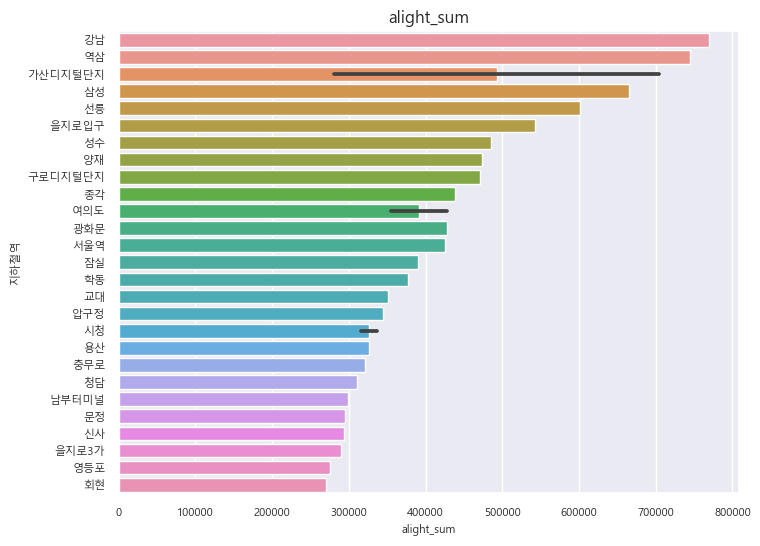

In [12]:
get_subway_barplot(df_filtered, 'alight_sum','지하철역', 'alight_sum')

![Alt text](./Data/img/분석4표.png)
<!-- <style type="text/css">
.tg  {border-collapse:collapse;border-color:#ccc;border-spacing:0;}
.tg td{background-color:#fff;border-color:#ccc;border-style:solid;border-width:1px;color:#333;
  font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{background-color:#f0f0f0;border-color:#ccc;border-style:solid;border-width:1px;color:#333;
  font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-trmu{background-color:#ffffff;border-color:#4d4747;font-family:Tahoma, Geneva, sans-serif !important;font-size:14px;
  text-align:center;vertical-align:top}
.tg .tg-hfcq{background-color:#d4dae4;border-color:#4d4747;color:#000000;font-family:Tahoma, Geneva, sans-serif !important;
  font-size:14px;font-weight:bold;text-align:center;vertical-align:top}
.tg .tg-hhed{background-color:#ffffff;border-color:#4d4747;font-family:Tahoma, Geneva, sans-serif !important;font-size:14px;
  text-align:center;vertical-align:top}
</style>

<table class="tg">
<thead>
  <tr>
    <th class="tg-hfcq">노선명</th>
    <th class="tg-hfcq">기점, 종점</th>
    <th class="tg-hfcq">인근 역</th>
    <th class="tg-hfcq">다람쥐버스 정류장</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-trmu">8552</td>
    <td class="tg-trmu">종점</td>
    <td class="tg-trmu">신림</td>
    <td class="tg-trmu">신림사거리.신림역</td>
  </tr>
  <tr>
    <td class="tg-hhed">8331</td>
    <td class="tg-hhed">종점</td>
    <td class="tg-hhed">잠실</td>
    <td class="tg-hhed">잠실역 8번출구</td>
  </tr>
  <tr>
    <td class="tg-trmu">8551</td>
    <td class="tg-trmu">기점</td>
    <td class="tg-trmu">봉천</td>
    <td class="tg-trmu">봉천역</td>
  </tr>
  <tr>
    <td class="tg-hhed">8551</td>
    <td class="tg-hhed">종점</td>
    <td class="tg-hhed">노량진</td>
    <td class="tg-hhed">노량진역 3번출구</td>
  </tr>
</tbody>
</table>

- 다람쥐 버스의 기점, 종점 14개 중 4개만 승차 수 Top 30인 지하철역과 연관있음.

<style type="text/css">
.tg  {border-collapse:collapse;border-color:#ccc;border-spacing:0;}
.tg td{background-color:#fff;border-color:#ccc;border-style:solid;border-width:1px;color:#333;
  font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{background-color:#f0f0f0;border-color:#ccc;border-style:solid;border-width:1px;color:#333;
  font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-trmu{background-color:#ffffff;border-color:#4d4747;font-family:Tahoma, Geneva, sans-serif !important;font-size:14px;
  text-align:center;vertical-align:top}
.tg .tg-hfcq{background-color:#d4dae4;border-color:#4d4747;color:#000000;font-family:Tahoma, Geneva, sans-serif !important;
  font-size:14px;font-weight:bold;text-align:center;vertical-align:top}
</style>
<table class="tg">
<thead>
  <tr>
    <th class="tg-hfcq">노선명</th>
    <th class="tg-hfcq">기점, 종점</th>
    <th class="tg-hfcq">인근 역</th>
    <th class="tg-hfcq">다람쥐버스 정류장</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-trmu">8331</td>
    <td class="tg-trmu">종점</td>
    <td class="tg-trmu">잠실</td>
    <td class="tg-trmu">잠실역 8번출구</td>
  </tr>
</tbody>
</table>

- 다람쥐 버스의 기점, 종점 14개 중 1개만 하차 수 Top 30인 지하철역과 연관있음. -->


> #### **<분석 4-1 결론>**
> - 다람쥐 버스의 기점, 종점이 반드시 승/하차 인구 수(유동인구 수)가 많은 지하철 역의 인근에 있는 것은 아니다.
> - 즉, 다람쥐 버스의 기점, 종점을 선정할 때 유동인구가 절대적인 기준이 되지는 않는다.
> - 유동인구 외 정류장 주변의 인프라를 추가로 4-2에서 분석함
<b>

## 4-2. 다람쥐 버스 기, 종점의 인프라, 인구 특징 분석

In [13]:
df_scaled = get_scaled_daram_df()

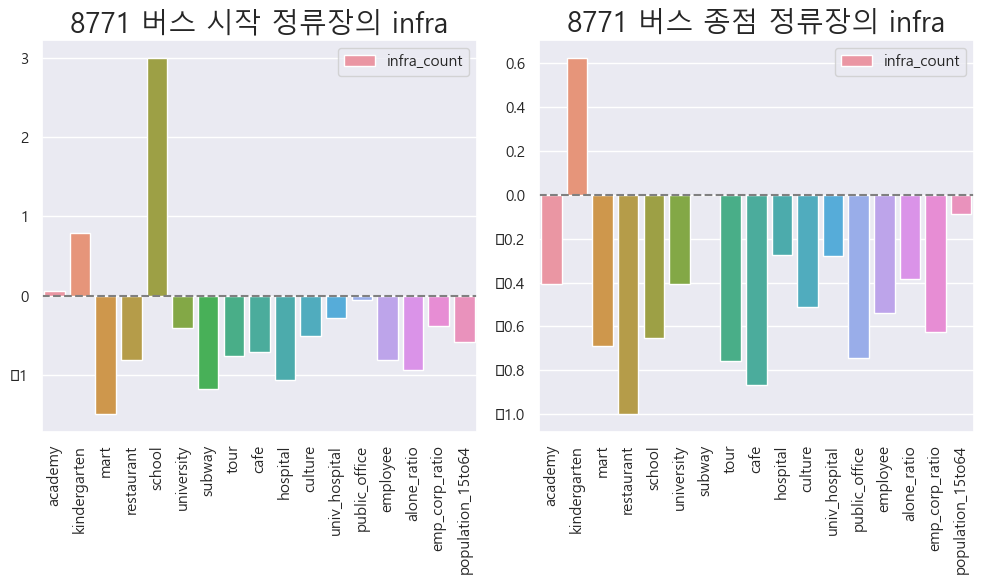

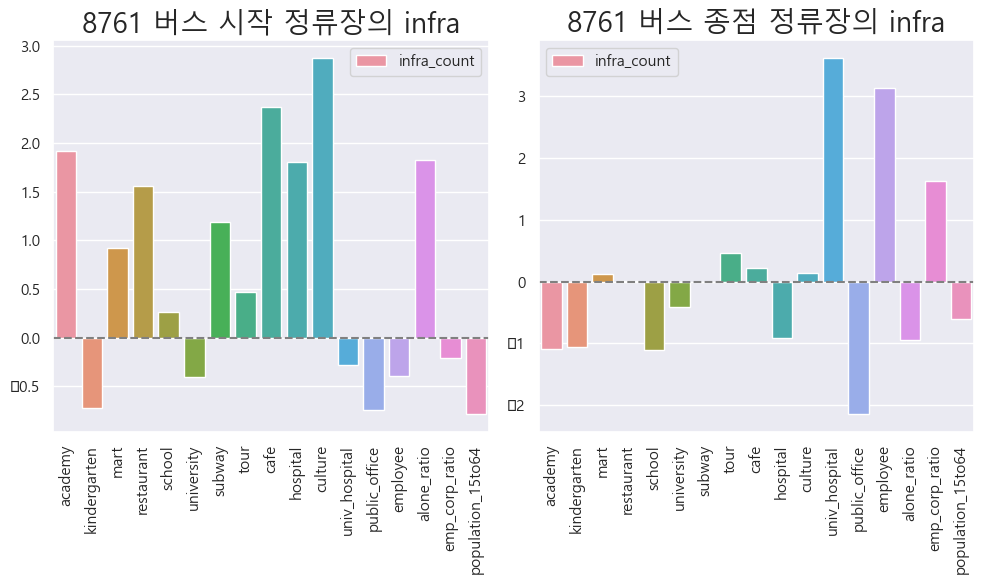

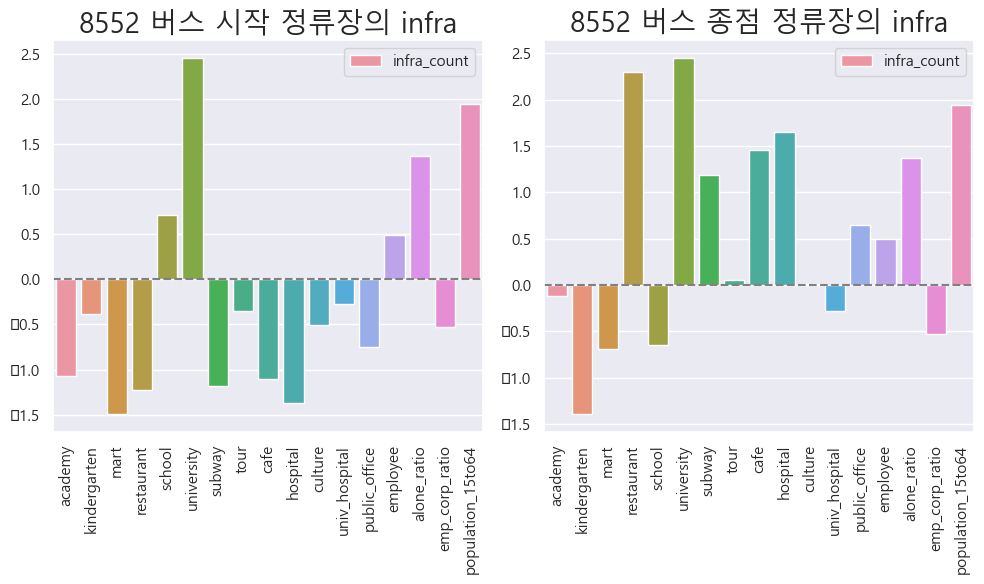

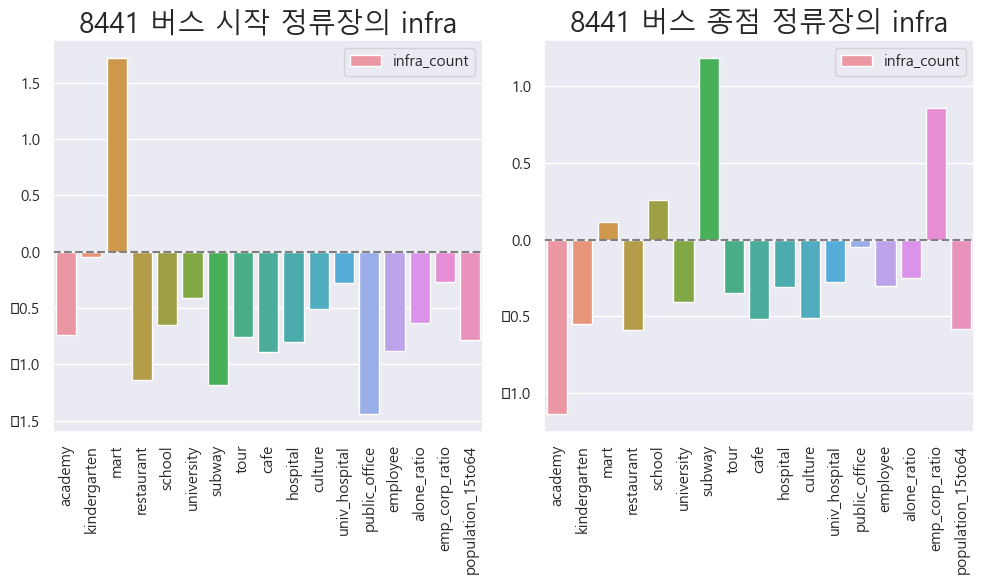

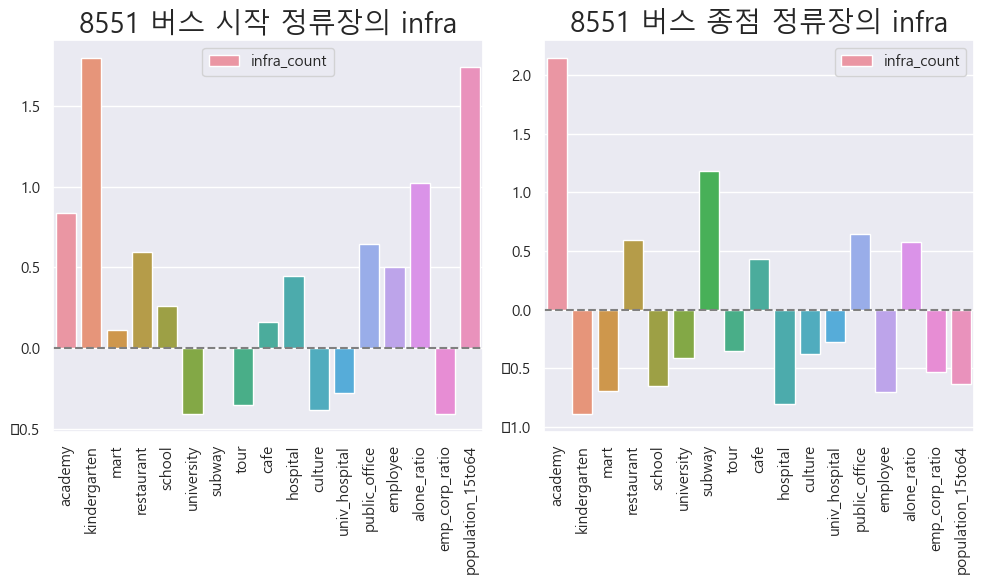

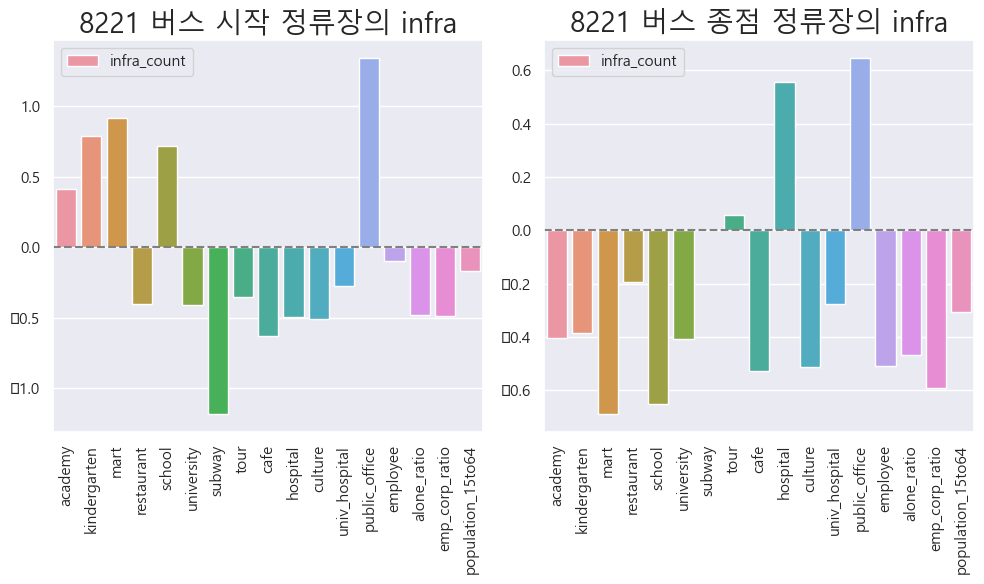

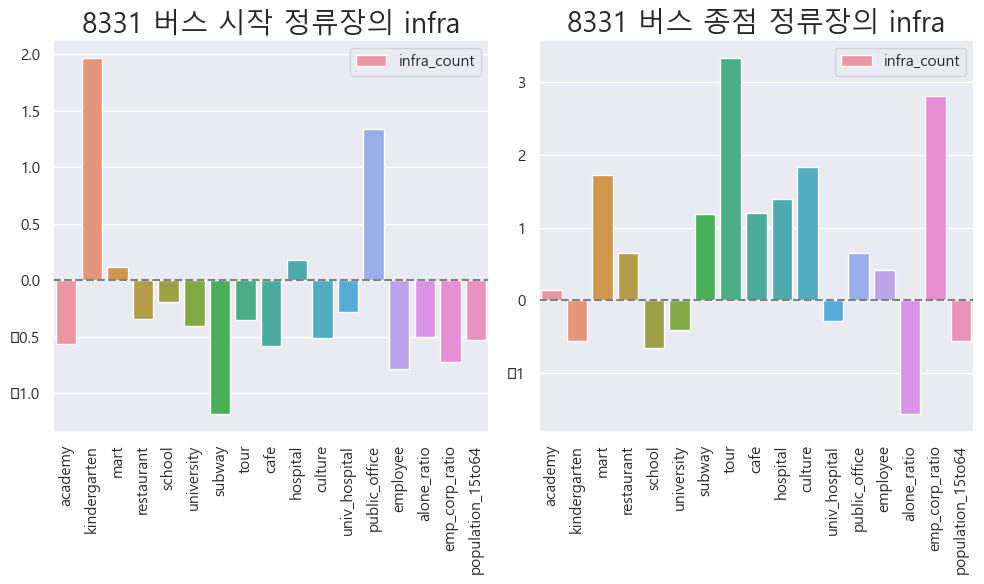

In [14]:
get_barplot_start_end(df_scaled)

> #### **<분석 4-2 결과>**
> ![Alt text](./Data/img/분석4_기종점표.png)
> - 기존 다람쥐 버스의 유형은 크게 3가지로 나뉜다.
>   - 거주지 - 거주지 (편도)
>   - 번화가 - 번화가 (왕복)
>   - 거주지 - 번화가 (편도, 왕복)
>  <br></br>
> - __기존 다람쥐 버스 `기점`의 특징__
>   - 인근 지하철역 수: 0~2개까지 다양하게 혼재
>   - 인프라 특징: 인근 지하철역이 0개인 곳은 거주지 & 편도 운행의 특징을 지님
> <br></br>
> - __기존 다람쥐 버스 `종점`의 특징__
>   - 인근 지하철역 수: 모두 1개 이상
>   - 인프라 특징: 거주지, 업무지구, 번화가 등 다양한 특징을 지님.
> <br></br>
> - 종합
>   - 기존 다람쥐 버스는 기점, 종점 인근(500m 이내)의 지하철 수의 합이 1개 이상이다.
>   - 편도 노선은 기점이 거주지의 특성을 지님. 
>   - 다람쥐 버스 유형
>      - 편도: 대부분 주거지 - 지하철역 잇고 있음.
>      - 왕복: 지하철역 - 지하철역 잇고 있음.
>   - 대부분의 다람쥐 버스는 거주지에서 지하철로 승객을 수송하는 역할을 한다. 

> - 종합적인 내용을 바탕으로 신설 다람쥐 노선 지역의 선정 기준을 산출함.
><br></br>
> - #### <b>✅선정 기준:  새로운 다람쥐 버스의 기점, 종점 인근에는 지하철이 1개 이상이어야 함 </b>

> ### **EDA 중간정리 (기존 다람쥐 버스 분석)**
> - 다람쥐 버스의 기점, 종점을 선정할 때 유동인구가 절대적인 기준이 되지는 않는다.
> - 정류장마다 인프라 특성이 다양하다.
>   - 기존 다람쥐 버스는 정류장의 다양한 인프라 특성을 반영하여 선정했을 것으로 추측됨
> - 따라서 새로운 다람쥐 버스의 정류장은 기존 다람쥐 버스 정류장의 특성을 바탕으로 선정할 것 → 유사도 이용
<b>

---

# 5. 유사도 활용        
### 유사도를 활용해 다람쥐 버스 정류장과 비슷한 정류장 탐색     


In [15]:
import numpy as np
import pandas as pd 
from Modeling.similarity import *

## 5-1. 데이터 전처리 

데이터 설명     
1. `daram_df` : 다람쥐 버스가 지나가는 95개의 정류장 데이터  
   `reset_daram_df` : `daram_df` 인덱스 초기화     
2. `similarity_reset_daram_df` : `reset_daram_df`를 유사도에 사용할 수 있게, 인프라 컬럼들만 추출한 데이터      
3. `label_bus_df` : 다람쥐버스정류장은 1, 일반 버스 정류장은 0으로 라벨링한 데이터     
4. `original_bus_df` : 일반 버스 정류장 데이터     
   `reset_original_bus_df` : 인덱스를 초기화한 일반 버스 정류장 데이터

### 1) 데이터 가져오기 

In [16]:
# 다람쥐 버스 정류장 데이터 
daram_df =pd.read_csv('./Data/csv/darambus.csv', encoding='UTF-8')
# 인덱스 초기화 
reset_daram_df = daram_df.reset_index()
# 유사도에 사용할 수 있게 데이터 프레임 만들기 
similarity_reset_daram_df = reset_daram_df.loc[:,'academy_cnt':'population_15to64']
# 라벨링된 전체 데이터 가져오기
label_bus_df = pd.read_csv('./Data/csv/bus_labels.csv', encoding='UTF-8')  

In [17]:
# 전체 데이터에서 다람쥐버스 정류장만 제거하기
original_bus_df=label_bus_df[label_bus_df['Label']==0]
# 인덱스 리셋
reset_original_bus_df= original_bus_df.reset_index()

### 2) 다람쥐 버스 정류장과 기존 버스 정류장 전처리

### 2-1) 다람쥐 버스 정류장만 추출하기

In [18]:
# 다람쥐 버스 데이터 분할 
    # 1. 시작점과 끝점 데이터만 
start_station = [111000128,113000113,120000156,120000109,105000127,122000305,123000209]
end_station =   [111000291,118000048,119000024,120000018,105000072,122000302,123000043]

st_end_station_list = start_station + end_station

### 2-2) 다람쥐 버스가 지나가는 정류장만 추출하기 

In [19]:
st_end_daram_df=reset_daram_df[reset_daram_df['NODE_ID'].isin(st_end_station_list)]

### 3-1) 유사도에 쓰일 다람쥐 버스 정류장 (시작-종점) 데이터 프레임 만들기 : sim_st_daram_df : 14행

In [20]:
sim_st_end_daram_df=st_end_daram_df.loc[:,'academy_cnt':'population_15to64'] 

### 3-2) 유사도에 쓰일 기존 버스 정류장 데이터 프레임만들기 : sim_reset_original_bus_df : 약 12000행

In [21]:
sim_reset_original_bus_df=reset_original_bus_df.loc[:,'academy_cnt':'population_15to64']

## 5-2. 유사도 이용하기 

### 1) 다람쥐 버스의 시작점과 끝점만 있는 정류장 : 14개   
: 유클라디안, 코사인 유사도 + 시각화 

##### eu : 유클라디안,  co : 코사인

- 유사도 데이터 추출

In [22]:
# 기본 자료 정리 : 기존 데이터와 유사한 데이터를 100개 추출할 것.
num_similar = 100
df_A = sim_st_end_daram_df
df_B = sim_reset_original_bus_df

# 유클라디안 : 앞에 eu로 표시
eu_similar_st_end_data = euclidean_similar_data(df_A, df_B, num_similar)

# 코사인 : 앞에 co로 표시
co_similar_st_end_data = cosine_similar_data(df_A, df_B, num_similar)

co_list=co_similar_st_end_data.index.values.tolist()


cosine_daram_df=pd.DataFrame()
for index,rows in reset_original_bus_df.iterrows():
    
    if index in co_list:
        cosine_daram_df=pd.concat([cosine_daram_df,rows], axis=1)   

cosine_daram_df=cosine_daram_df.T

# 유클라디안 인덱스를 추출 
eu_similar_st_end_index = eu_similar_st_end_data.index.values
eu_similar_st_end_index_list = eu_similar_st_end_index.tolist()
# 잘뽑았나 개수 확인~
print(len(eu_similar_st_end_index_list))

# 코사인 인덱스 추출 
co_similar_st_end_index = co_similar_st_end_data.index.values
co_similar_st_end_index_list = co_similar_st_end_index.tolist()
# 잘뽑았나 개수 확인~
print(len(eu_similar_st_end_index_list))

#원하는 행만 추출 
    # 다람쥐 버스 (시작_끝)
eu_original_st_end_df=reset_original_bus_df.loc[eu_similar_st_end_index_list]
co_original_st_end_df=reset_original_bus_df.loc[co_similar_st_end_index_list]

1400
1400


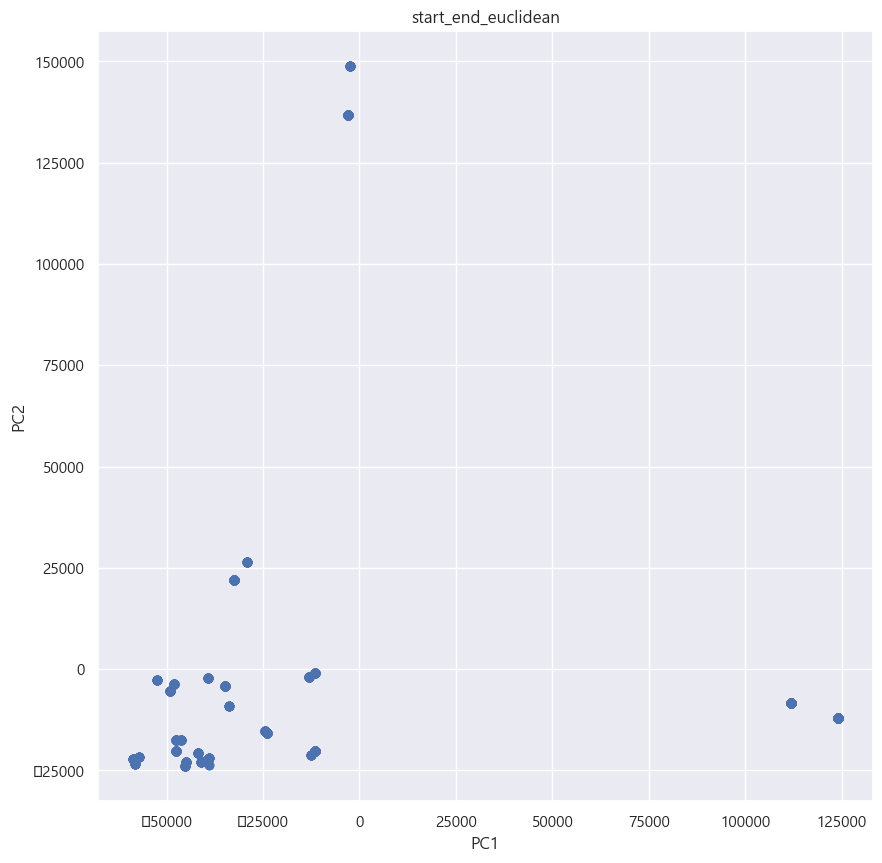

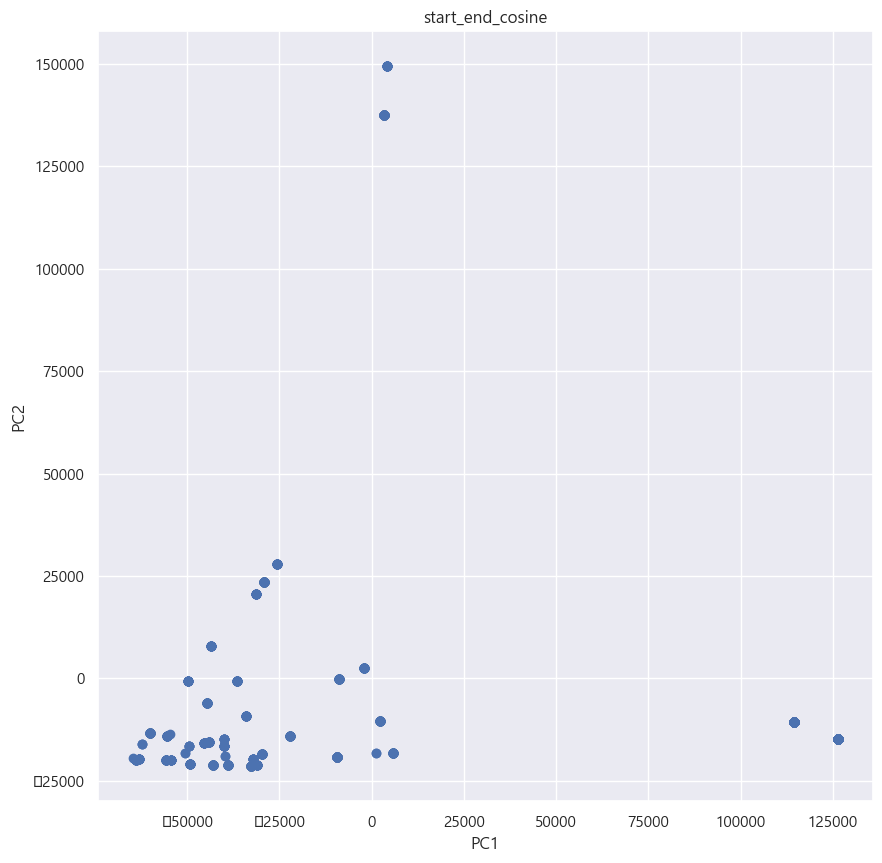

In [23]:
# 기점 종점 14개 유클라디안, 코사인 유사도 결과 시각화
visualize_similar_data('start_end_euclidean',eu_similar_st_end_data)
visualize_similar_data('start_end_cosine',co_similar_st_end_data)

- Folium에 시각화하기 

In [24]:
#visualize_similar_data_on_map('14_eu_st_end_similarity.html',eu_original_st_end_df,daram_df)
#visualize_similar_data_on_map('14_co_st_end_similarity.html',co_original_st_end_df,daram_df)

### 2) 다람쥐 버스 전체 정류장 : 95개    
: 유클라디안, 코사인 유사도 + 시각화 

In [25]:
num_similar = 30

df__A = similarity_reset_daram_df
df__B = sim_reset_original_bus_df
co_similar_data = cosine_similar_data(df__A, df__B, num_similar)

# 코사인 인덱스 추출 
co_similar_index = co_similar_data.index.values
co_similar_index_list = co_similar_index.tolist()

#원하는 행만 추출 
    # 다람쥐 버스 (시작_끝)
co_original_df=reset_original_bus_df.loc[co_similar_index_list]

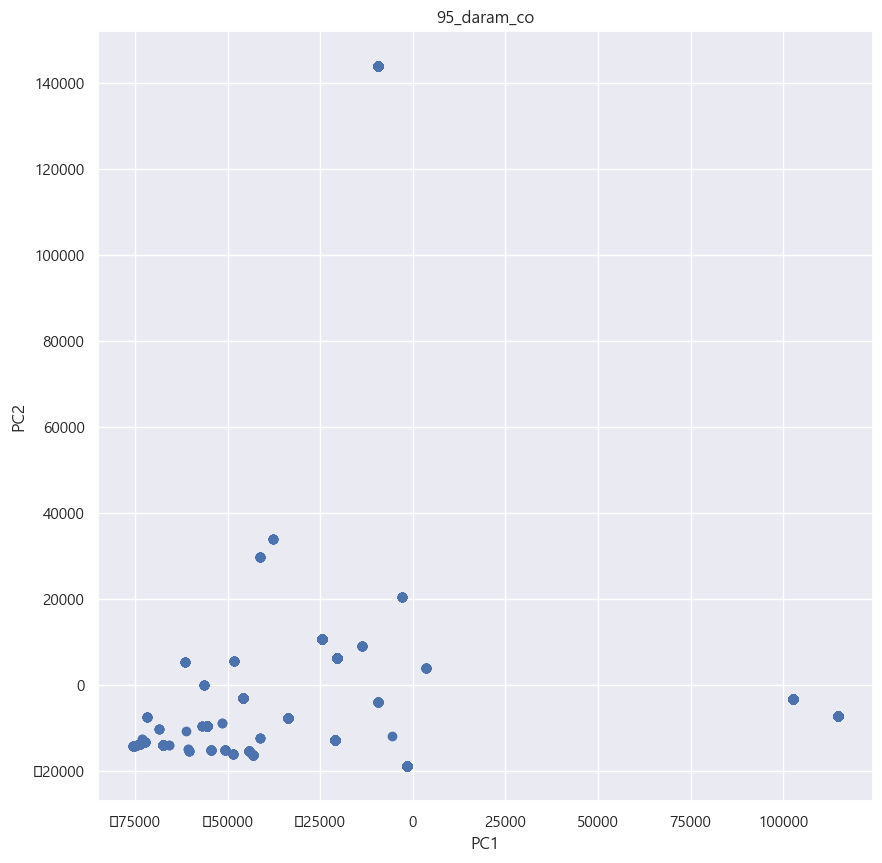

In [26]:
visualize_similar_data('95_daram_co',co_similar_data)

- Folium에 시각화 하기

In [27]:
#visualize_similar_data_on_map('95_co_similarity.html',co_original_df,daram_df)

>#### **<다람쥐버스 14개의 시작점,종점 정류장 데이터와 95개의 다람쥐버스 전체 정류장 데이터를 비교한 결과>**     
 ><br>
> - 유클라디안 유사도 VS 코사인 유사도 [기점-종점 14개]     
>PCA에서는 큰 차이가 없지만, FOlium에서14개의 데이터의 코사인 유사도가 유클라디안 유사도보다 더 기존의 정류장들과 일치하면서 새로운 정류장까지 더 잘 찾아내는 경향을 보임 → 다람쥐 버스 정류장과 비슷한 특성을 가진 지역을 찾으려면 코사인 유사도가 더 적합하다고 판단
><br>
> - 코사인 유사도 95개 VS 14개  
>유사도를 활용했을 때 14개 데이터가 95개 데이터보다 기존의 정류장들과 일치하면서 새로운 정류장까지 더 잘 찾아내는 경향을 보임 .    
><br>  
> - 코사인 유사도를 최종 선택  


| 14_euclidean  | 14_cosine   | 95_cosine   |
|---|---|---|
| <img src="Data/img/PCA_eu_14.png" width="500">  | <img src="Data/img/PCA_co_14.png" width="500"> |  <img src="Data/img/PCA_co_95.png" width="500"> |
| <img src="Data/img/folium_eu_14.png" width="500">  | <img src="Data/img/folium_co_14.png" width="500"> | <img src="Data/img/folium_co_95.png" width="500">  |             


In [28]:
df_similar=co_original_st_end_df.drop(['Unnamed: 0','RIDE_SUM_6_10','ALIGHT_SUM_6_10'],axis=1)
df_similar.rename(columns={'Label':'station_label'}, inplace=True)
df_similar=df_similar.drop_duplicates()

---

## 6. Clustering

<진행 순서>  
1. 서울의 기존 정류장들(약 12500개) 중 다람쥐 버스 정류장(95개)을 제외한 나머지 정류장들 중 기존 다람쥐 버스 정류장의 기점, 종점(14개)과 높은 유사도를 지닌 정류장을 100개씩 뽑아 총 1400 정류장으로 추림.
2. 추려진 정류장을 바탕으로 군집 진행하여 특성 파악 
- 코사인 유사도를 통해 추출한 1400개의 정류장을 군집.
- 사용기술:
    - Kmeans
    - GMM
    - DBscan

In [29]:
df_bus_not_daram = get_not_daram_station()

# numerical data만 추출
df_bus_not_daram_num = df_bus_not_daram.select_dtypes(include=['int','float'])

# df_daram_14: 다람쥐버스 기,종점(14개) 데이터프레임
df_daram_14 = get_daram_14_station_df()
df_daram_14 = preprocessing_cluster(df_daram_14)

# numerical data만 추출
df_daram_14_num = df_daram_14.select_dtypes(include=['int','float'])

## 6-1. scaler & pca

### 1) scaler

In [30]:
df_similar_num = df_similar.select_dtypes(include=['int','float'])
df_similar_num = df_similar_num.reset_index(drop=True)
df_similar_num=df_similar_num.drop(['NODE_ID','X좌표','Y좌표','법정동코드'], axis=1)

drop_col = ['index','station_label']
df_similar_num = df_similar_num.drop(drop_col, axis =1)
df_similar_num.head()

,academy_cnt,kindergarten_cnt,mart_cnt,restaurant_cnt,school_cnt,university_cnt,subway_cnt,tour_cnt,cafe_cnt,hospital_cnt,culture_cnt,univ_hospital_cnt,public_office_cnt,employee_cnt,alone_ratio,emp_corp_ratio,population_15to64
0,44,9,1,333,1,0,1,1,52,55,0,0,3,18996,0.129167,3.160732,40211
1,45,13,1,335,2,0,1,1,55,52,0,0,6,18996,0.129167,3.160732,40211
2,47,10,1,345,1,0,1,1,55,55,0,0,3,18996,0.129167,3.160732,40211
3,47,13,1,347,1,0,1,2,55,59,0,0,4,18996,0.129167,3.160732,40211
4,47,8,1,350,1,0,1,2,55,57,0,0,3,18996,0.129167,3.160732,40211


- boxplot으로 이상치 확인

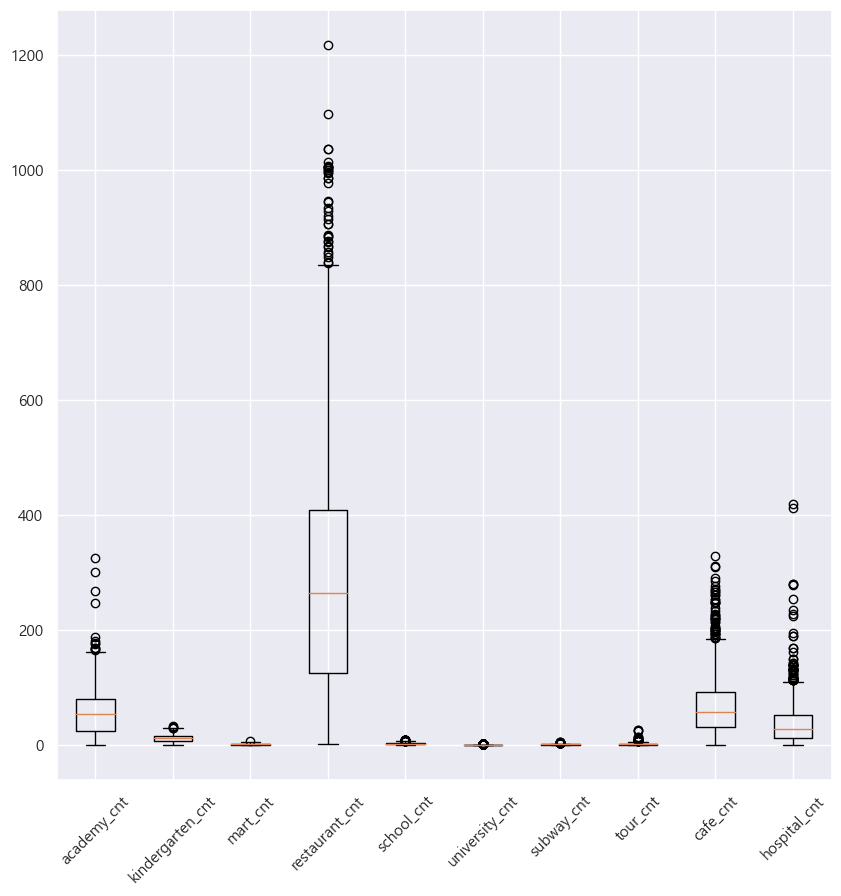

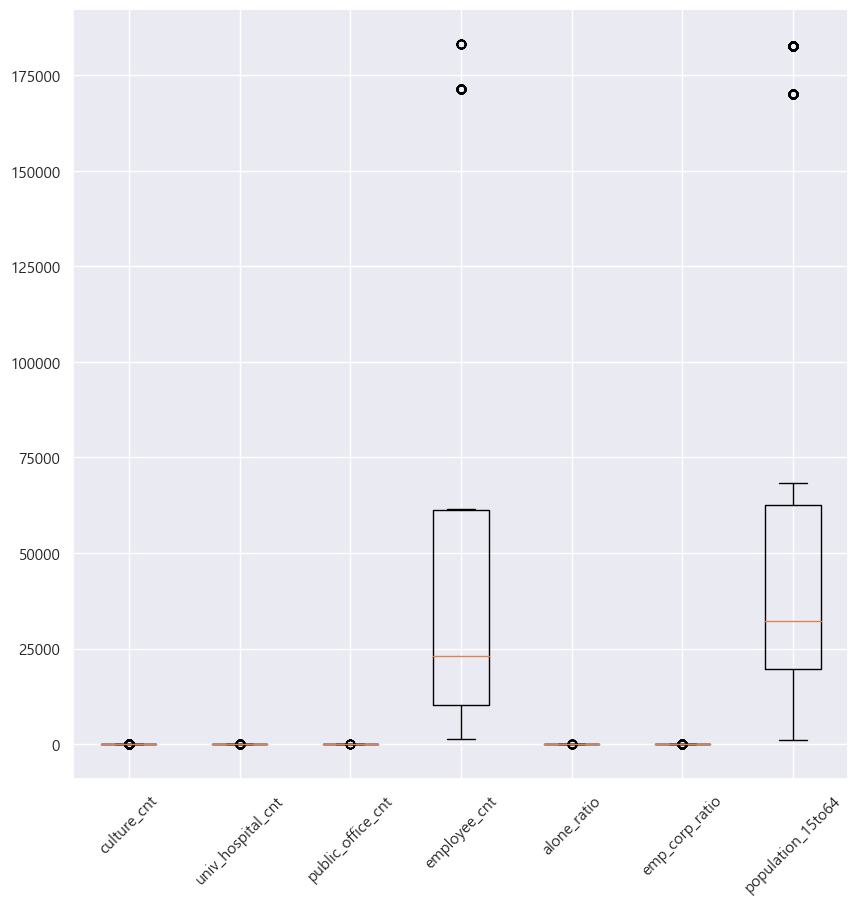

In [31]:
# Extract column names for each subset
subset1_columns = df_similar_num.columns[:10]
subset2_columns = df_similar_num.columns[10:]



plt.boxplot(df_similar_num.iloc[:, :10])
plt.xticks(range(1, len(subset1_columns) + 1), subset1_columns, rotation=45)
plt.show()


plt.boxplot(df_similar_num.iloc[:, 10:])
plt.xticks(range(1, len(subset2_columns) + 1), subset2_columns, rotation=45)
plt.show()

- 위의 boxplot을 살펴보면 academy, restaurant, hospital 등 이상치가 많은 데이터들이 있다.
- 중앙값과 IQR을 사용하여 이상치에 민감하지 않은 robust scaler를 사용했다.

In [32]:
df_robust = scaler(df_similar_num, 'robust')

### 2) PCA

- 현재 데이터는 17차원
- 데이터 피쳐 중 중요한 피처만 뽑아 모델의 설명력, 예측력을 더 높이기 위해 pca 선택


In [33]:
pca_explained_variance_ration(df_robust)

,설명가능한 분산 비율(고윳값),기여율,누적 기여율
pca_1,4.844769,0.316786,0.316786
pca_2,2.902126,0.189762,0.506548
pca_3,1.834720,0.119967,0.626515
pca_4,1.664089,0.108810,0.735325
pca_5,0.796443,0.052077,0.787403
pca_6,0.684906,0.044784,0.832187
pca_7,0.578047,0.037797,0.869984
pca_8,0.458740,0.029996,0.899979
pca_9,0.408462,0.026708,0.926687
pca_10,0.305056,0.019947,0.946634


- pca 차원 선택 기준 
    1. 누적 기여율 > 0.7

- 6차원으로 차원축소 결정

In [34]:
pca_6_df = func_pca(df_robust, 6)
pca_6_df

분산 설명력 :  0.8321866893735999


,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6
0,-0.707867,-0.299968,-0.787584,-0.055454,0.648526,0.995420
1,-0.630363,-0.176608,-1.352171,-0.415561,0.850213,0.171546
2,-0.687045,-0.279873,-0.864459,-0.078261,0.634682,0.987805
3,-0.544441,-0.167778,-1.101407,-0.077009,1.137501,0.738952
4,-0.561236,-0.217231,-0.770395,0.053938,1.042461,0.905232
...,...,...,...,...,...,...
1310,-1.331268,3.316142,0.551998,0.159381,0.539710,-0.072554
1311,-1.577837,3.148518,0.417780,-0.273740,-0.382467,-0.210888
1312,-1.575152,3.167108,0.282355,-0.136147,-0.377983,0.317397
1313,-1.059913,3.174297,0.507238,-0.344595,-0.470316,0.293153


## 6-2. kmeans

- kmeans의 군집개수 결정을 위해 사용한 method
  - elbow method
  - calinski score 
  - 실루엣 계수

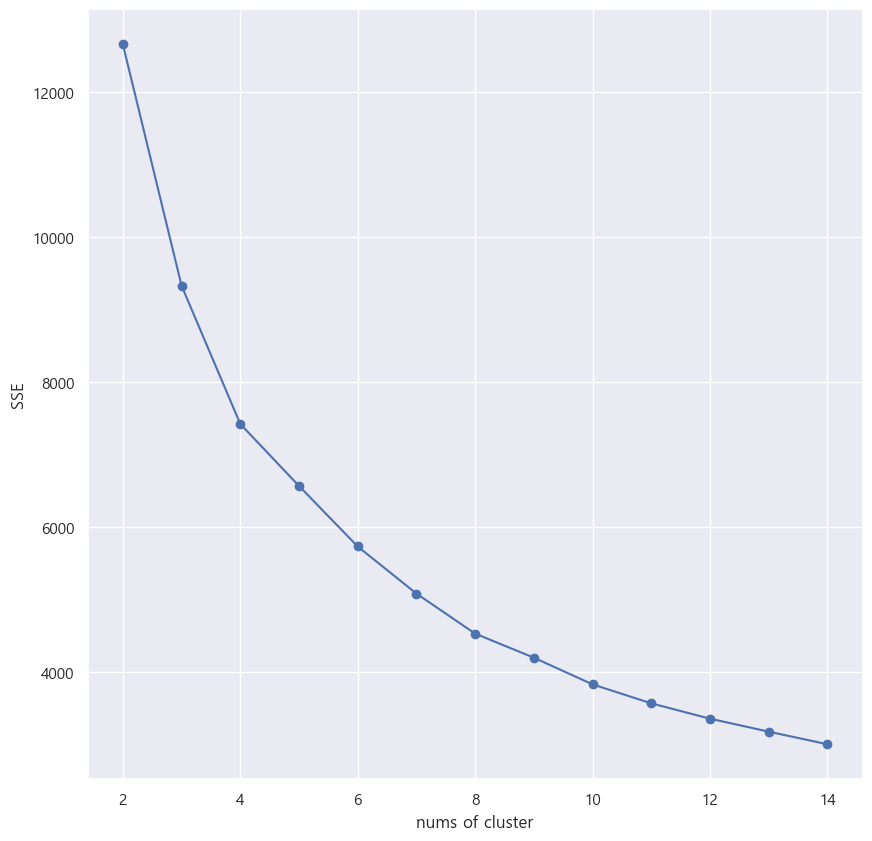

calinski-score 2 개 군집: 420.936471512023
calinski-score 3 개 군집: 519.5682927681275
calinski-score 4 개 군집: 547.2866280463548
calinski-score 5 개 군집: 506.17682371557953
calinski-score 6 개 군집: 501.7386749568386
calinski-score 7 개 군집: 499.018547975772
calinski-score 8 개 군집: 502.2633636649498
calinski-score 9 개 군집: 486.7456380422332
calinski-score 10 개 군집: 487.8173628067097
calinski-score 11 개 군집: 480.4392582866576
calinski-score 12 개 군집: 471.3932718347889
calinski-score 13 개 군집: 462.18969463703127
calinski-score 14 개 군집: 456.73986124293805


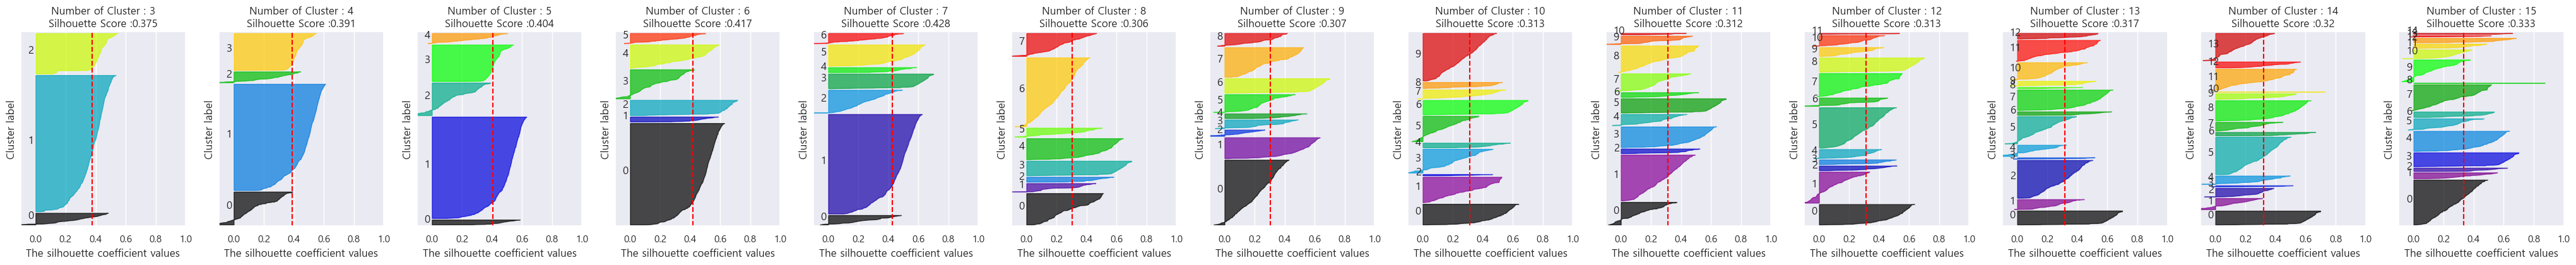

In [35]:
elbow_method(2, 15, pca_6_df)
visualize_silhouette([3,4,5,6,7,8,9,10,11,12,13,14,15],pca_6_df)
calinski_harabasz(2,15, pca_6_df)

- elbow method: 군집 개수 9개에서 기울기가 완만해지기 시작.
- calinski-score:  군집 개수 2~4, 9에서 calinski-score가 상승세. 
- 실루엣 계수: 모두 실루엣 계수가 낮지만, 군집 개수 10~11개가 군집 간 비율이 적절하게 나뉘어졌다고 생각.  
<br></br>
- 최종 군집 개수: 세개의 method를 모두 고려했을 때, Kmeans의 군집 개수는 10개가 가장 적당하다고 생각되어 8개로 결정.

In [36]:
df_kmeans = clustering_kmeans(pca_6_df,10,'k-means++',300,0)
kmeans_label = df_kmeans['kmeans_label']

df_kmeans_standard = df_similar[::]
df_kmeans_standard['kmeans_label'] = df_kmeans['kmeans_label'].values

In [37]:
# folium_bus(None, None,None,df_kmeans_standard,'kmeans_label',"hybrid")

![Alt text](./Data/img/KMEANS.png)

## 6-3. GMM

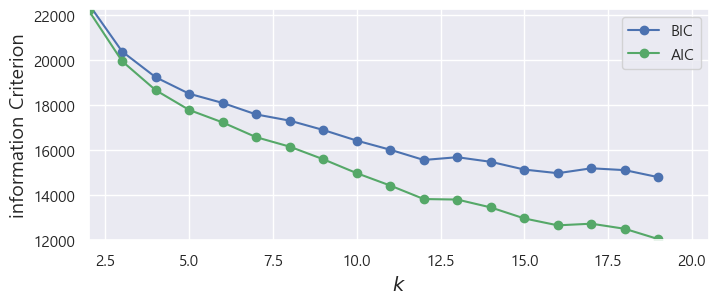

In [38]:
bic_aic(pca_6_df, 2, 20)

bic-aic 그래프에서 군집갯수가 11개일 때, 변곡점이므로 군집 갯수를 11개로 정함.

In [39]:
df_gmm = clustering_gmm(pca_6_df, 11, 42)
df_gmm

,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,gmm_label
0,-0.707867,-0.299968,-0.787584,-0.055454,0.648526,0.995420,7
1,-0.630363,-0.176608,-1.352171,-0.415561,0.850213,0.171546,7
2,-0.687045,-0.279873,-0.864459,-0.078261,0.634682,0.987805,7
3,-0.544441,-0.167778,-1.101407,-0.077009,1.137501,0.738952,7
4,-0.561236,-0.217231,-0.770395,0.053938,1.042461,0.905232,7
...,...,...,...,...,...,...,...
1310,-1.331268,3.316142,0.551998,0.159381,0.539710,-0.072554,2
1311,-1.577837,3.148518,0.417780,-0.273740,-0.382467,-0.210888,2
1312,-1.575152,3.167108,0.282355,-0.136147,-0.377983,0.317397,2
1313,-1.059913,3.174297,0.507238,-0.344595,-0.470316,0.293153,2


In [40]:
df_gmm_robust_pca = df_similar.copy()
df_gmm_robust_pca['gmm_label']  = df_gmm['gmm_label'].values
df_gmm_robust_pca['gmm_label'].nunique()

11

In [41]:
# folium_bus(None, None,None,df_gmm_robust_pca,'gmm_label',"hybrid")

![Alt text](./Data/img/GMM.png)

## 6-4. DBSCAN

In [42]:
import pandas as pd 
DB_SCAN_daram_1400_df = pd.read_csv('./Data/csv/cosine_similarity_daram.csv', encoding='UTF-8')
# 기본 정보들을 제외한 Feature와 Label을 나누기 
DB_Feature_df= DB_SCAN_daram_1400_df.loc[:,'academy_cnt':'population_15to64']
DB_Label_df = DB_SCAN_daram_1400_df['Label']

# 스케일링 종류별로 만들어 놓기 (Min_Max,Standard, Robust)

from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler 

standard_scaler = StandardScaler()
standard_df = standard_scaler.fit_transform(DB_Feature_df)

minmax_scaler = MinMaxScaler()
minmax_df = minmax_scaler.fit_transform(DB_Feature_df)

robust_scaler = RobustScaler()
robust_df = robust_scaler.fit_transform(DB_Feature_df)

# PCA 하기 
import numpy as np 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
DB_ready_df=DBSCAN_PCA(DB_SCAN_daram_1400_df)
DB_ready_df

,0,1,Label
0,-1.793953,0.419566,0
1,-1.744842,0.287092,0
2,-2.416116,0.260631,0
3,-2.595820,0.564651,0
4,-2.083299,0.997204,0
...,...,...,...
1310,3.592615,0.055009,0
1311,3.614697,-0.044837,0
1312,3.700709,0.105294,0
1313,0.635479,-2.102950,0


##### DBSCAN에서 최적의 파라미터를 찾기

In [43]:
# DBSACN 
from sklearn.cluster import DBSCAN


dbscan = DBSCAN(eps=3, min_samples=2)
dbscan_labels = dbscan.fit_predict(DB_ready_df[[0,1]])
scale_list = [DB_Feature_df, standard_df, minmax_df, robust_df]
# eps과 min_samples를 변화시키면서 DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN

column_length = DB_Feature_df.shape[1] 

eps_list = [0.3,0.5,1,1.5]
min_samples_list = [10,30,50,70]
method_list = ['Unscaled Data:', 'Standard Scaled Data:', 'Minmax Scaled Data:', 'Robust Scaled Data:']

pca_list = [2, 7, 8, 15]

search_bset_parameter_DBSCAN(eps_list,min_samples_list,method_list,pca_list,scale_list)

Unscaled Data:
eps: 0.3, min_samples: 10, pca: 2, Silhouette score: 0.9580895591144137
eps: 0.3, min_samples: 30, pca: 2, Silhouette score: 0.5487522505465154
eps: 0.3, min_samples: 50, pca: 2, Silhouette score: -0.05077404829589592
eps: 0.3, min_samples: 70, pca: 2, Silhouette score: -0.008263031567512754
eps: 0.5, min_samples: 10, pca: 2, Silhouette score: 0.9597269371166596
eps: 0.5, min_samples: 30, pca: 2, Silhouette score: 0.5545177053331241
eps: 0.5, min_samples: 50, pca: 2, Silhouette score: 0.1317022623295295


eps: 0.5, min_samples: 70, pca: 2, Silhouette score: 0.24667751541660332
eps: 1, min_samples: 10, pca: 2, Silhouette score: 0.9597269371166596
eps: 1, min_samples: 30, pca: 2, Silhouette score: 0.5545177053331241
eps: 1, min_samples: 50, pca: 2, Silhouette score: 0.1317022623295295
eps: 1, min_samples: 70, pca: 2, Silhouette score: 0.2975980851002526
eps: 1.5, min_samples: 10, pca: 2, Silhouette score: 0.9597269371166596
eps: 1.5, min_samples: 30, pca: 2, Silhouette score: 0.5545177053331241
eps: 1.5, min_samples: 50, pca: 2, Silhouette score: 0.1317022623295295
eps: 1.5, min_samples: 70, pca: 2, Silhouette score: 0.2975980851002526


Standard Scaled Data:
eps: 0.3, min_samples: 10, pca: 2, Silhouette score: 0.006119612083730555
eps: 0.3, min_samples: 30, pca: 2, Silhouette score: 0.04000620930138207
eps: 0.3, min_samples: 50, pca: 2, Silhouette score N/A for single cluster.
eps: 0.3, min_samples: 70, pca: 2, Silhouette score N/A for single cluster.
eps: 0.5, min_samples: 10, pca: 2, S

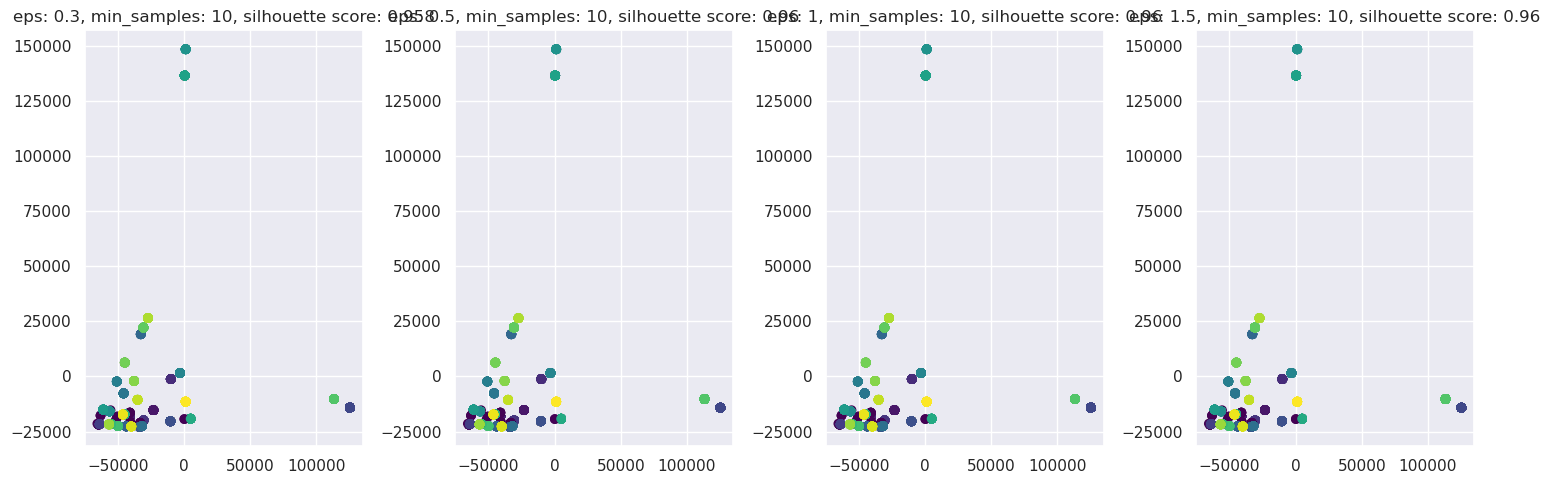

In [44]:
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['font.family'] = 'DejaVu Sans'

eps_list = [0.3,0.5,1,1.5]
min_samples_list = [10]

pca = PCA(n_components=2)
feature_df_pca = pca.fit_transform(DB_Feature_df)



labels=best_parameter_visualization_DBSCAN(eps_list,min_samples_list,feature_df_pca)

여러가지 최적의 파라미터를 찾은 결과, 가장 높은 실루엣 스코어는 0.96이다.

In [45]:
DB_SCAN_Folium_df = DB_SCAN_daram_1400_df.assign(C=labels)

In [65]:
# DBSCAN_folium(DB_SCAN_Folium_df)

<img src="Data/img/DBSCAN_Folium.png" >

# 6-5. clustering 결론

#### 1) 군집별 결과 비교  
|   |  GMM | KMEANS   | DBSCAN   |
|---|---|---|---|
|  군집결과 | <img src="Data/img/GMM_Folium.png" width="400"> |  <img src="Data/img/K-means_Folium.png" width="400">   |  <img src="Data/img/DBSCAN_Folium.png" width="400">   |

- GMM 
  - 군집 11개 
  - 노선에 따라서 군집이 잘됨
  - 군집별 특성이 잘 보임 
  
- K-Means
  - 8개 군집
  - 여러 클래스가 한 지역내에 뭉쳐있어, 군집별 특징이 뚜렷하지 않음.

- DBSCAN  
  - 군집 7개
  - 군집의 변별력이 없음.



> 시도해본 clustering 종류: GMM, KMeans, DBscan   
> 세가지 clustering 중 군집 간의 변별력이 가장 높고 각 군집의 특성이 잘 보이는 clustering은 GMM이었다.  
> ☑️최종 군집 방법 : GMM

#### 2) GMM 군집 결과 해석

##### GMM 군집별 특징

<img src="Data/img/GMM_특징분석.png" width="700">

> - 기존 노선들의 군집을 살펴보니 아래의 사실을 발견.  
>   - 기점이 거주지인 노선 → 기점-종점의 클러스터 동일 or 상이
>   - 기점이 거주지가 아닌 번화가, 업무지구인 노선  →  기점-종점의 클러스터가 반드시 상이  
> <br></br>
> - 이 사실을 바탕으로 새로운 다람쥐 버스의 노선을 설정할 때 참고할 기준3을 설정.
  

> #### ✅선정 기준: 
> - 기점이 거주지일 때 → 기, 종점이 동일한 클러스터 or 기,종점이 서로 다른 클러스터.
> - 기점이 거주지가 아닐 때 → 기, 종점이 반드시 서로 다른 클러스터여야 함. 

---

# 7. 기준에 따라서 후보 정류장 제거하기 
- 유사도로 뽑힌 후보 정류장들을 기준에 따라서 제거한다.

> ### ✅기준
> - ##### 기준 1 : 새로운 다람쥐 버스 정류장은 기존 다람쥐 버스 정류장 같은 지역에 존재하면 안된다. 
> - ##### 기준 2 : 기점,종점 인근에 지하철역이 적어도 하나 이상은 있어야한다. 
> - ##### 기준 3 : 기점이 거주지가 아닐때, 기점과 종점이 반드시 서로 다른 클래스여야 한다. 

### 7-1. GMM 클러스터된 다람쥐 데이터 가져오기  
GMM 군집결과 총 11개의 클래스.

In [47]:
# gmm 다람쥐 csv 가져오기
gmm_daram_df = pd.read_csv('./Data/csv/gmm_daram.csv', encoding='UTF-8')
gmm_daram_df=gmm_daram_df[['X좌표','Y좌표','NODE_ID', 'gmm_cluster']]
gmm_daram_df

# 다람쥐 95개 정류장 csv 가져오기
daram_df = pd.read_csv('./Data/csv/다람쥐95개정류장.csv', encoding='cp949')

In [48]:
# gmm 클러스터링으로 라벨링된 데이터 확인하기 
gmm_daram_df

,X좌표,Y좌표,NODE_ID,gmm_cluster
0,126.918884,37.521891,118000076,0
1,126.930759,37.525932,118000613,0
2,126.893399,37.476205,117900029,0
3,126.924904,37.530782,118000051,0
4,126.920853,37.527967,118000196,0
...,...,...,...,...
1310,127.000648,37.593218,107000140,10
1311,126.897552,37.518672,118900051,10
1312,126.995944,37.593745,107000137,10
1313,127.001531,37.593272,107000141,10


### 7-2. 유사도 데이터 확인 

In [49]:
cosine_daram_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1315 entries, 35 to 12421
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   index              1315 non-null   object
 1   Unnamed: 0         1315 non-null   object
 2   NODE_ID            1315 non-null   object
 3   정류소명               1315 non-null   object
 4   X좌표                1315 non-null   object
 5   Y좌표                1315 non-null   object
 6   법정동코드              1315 non-null   object
 7   법정동_구              1315 non-null   object
 8   법정동                1315 non-null   object
 9   academy_cnt        1315 non-null   object
 10  kindergarten_cnt   1315 non-null   object
 11  mart_cnt           1315 non-null   object
 12  restaurant_cnt     1315 non-null   object
 13  school_cnt         1315 non-null   object
 14  university_cnt     1315 non-null   object
 15  subway_cnt         1315 non-null   object
 16  tour_cnt           1315 non-null   objec

### 7-3. 95개 다람쥐 버스 정류장에 gmm 군집결과 merge

In [50]:
gmm_daram_result_df = pd.merge(cosine_daram_df,gmm_daram_df, left_on='NODE_ID' ,right_on='NODE_ID',how='left')
gmm_daram_result_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1315 entries, 0 to 1314
Data columns (total 32 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   index              1315 non-null   object 
 1   Unnamed: 0         1315 non-null   object 
 2   NODE_ID            1315 non-null   object 
 3   정류소명               1315 non-null   object 
 4   X좌표_x              1315 non-null   object 
 5   Y좌표_x              1315 non-null   object 
 6   법정동코드              1315 non-null   object 
 7   법정동_구              1315 non-null   object 
 8   법정동                1315 non-null   object 
 9   academy_cnt        1315 non-null   object 
 10  kindergarten_cnt   1315 non-null   object 
 11  mart_cnt           1315 non-null   object 
 12  restaurant_cnt     1315 non-null   object 
 13  school_cnt         1315 non-null   object 
 14  university_cnt     1315 non-null   object 
 15  subway_cnt         1315 non-null   object 
 16  tour_cnt           1315 

In [51]:
cosine_daram_df['구-동']=cosine_daram_df['법정동_구']+cosine_daram_df['법정동']
daram_df['구-동']=daram_df['법정동_구']+daram_df['법정동']

### 7-3. GMM 클러스터링된 코사인 유사도에서 후보군 제거 

In [52]:
gmm_daram_df

,X좌표,Y좌표,NODE_ID,gmm_cluster
0,126.918884,37.521891,118000076,0
1,126.930759,37.525932,118000613,0
2,126.893399,37.476205,117900029,0
3,126.924904,37.530782,118000051,0
4,126.920853,37.527967,118000196,0
...,...,...,...,...
1310,127.000648,37.593218,107000140,10
1311,126.897552,37.518672,118900051,10
1312,126.995944,37.593745,107000137,10
1313,127.001531,37.593272,107000141,10


In [53]:
gmm_daram_result_df['구-동']=gmm_daram_result_df['법정동_구']+gmm_daram_result_df['법정동']
# 기존 다람쥐 버스 (95개)가 있는 동을 리스트로 뽑기 
daram_95_gu_list = daram_df['법정동_구'].drop_duplicates().tolist()
daram_95_gu_dong_list = daram_df['구-동'].drop_duplicates().tolist()
daram_95_gu_dong_list

['동대문구장안동',
 '동대문구답십리동',
 '송파구신천동',
 '송파구방이동',
 '송파구오금동',
 '송파구마천동',
 '강남구수서동',
 '강남구세곡동',
 '강남구자곡동',
 '동작구노량진동',
 '동작구상도동',
 '관악구봉천동',
 '관악구신림동',
 '마포구창전동',
 '마포구노고산동',
 '영등포구여의도동',
 '은평구신사동',
 '은평구응암동',
 '은평구구산동',
 '은평구역촌동']

In [54]:
gmm_daram_result_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1315 entries, 0 to 1314
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   index              1315 non-null   object 
 1   Unnamed: 0         1315 non-null   object 
 2   NODE_ID            1315 non-null   object 
 3   정류소명               1315 non-null   object 
 4   X좌표_x              1315 non-null   object 
 5   Y좌표_x              1315 non-null   object 
 6   법정동코드              1315 non-null   object 
 7   법정동_구              1315 non-null   object 
 8   법정동                1315 non-null   object 
 9   academy_cnt        1315 non-null   object 
 10  kindergarten_cnt   1315 non-null   object 
 11  mart_cnt           1315 non-null   object 
 12  restaurant_cnt     1315 non-null   object 
 13  school_cnt         1315 non-null   object 
 14  university_cnt     1315 non-null   object 
 15  subway_cnt         1315 non-null   object 
 16  tour_cnt           1315 

In [55]:
# 불필요한 컬럼 삭제 
gmm_daram_result_df.rename(columns={'X좌표_x':'X좌표','Y좌표_x' :'Y좌표'}, inplace=True)
gmm_daram_result_df.head()

,index,Unnamed: 0,NODE_ID,정류소명,X좌표,Y좌표,법정동코드,법정동_구,법정동,academy_cnt,...,alone_ratio,emp_corp_ratio,population_15to64,RIDE_SUM_6_10,ALIGHT_SUM_6_10,Label,X좌표_y,Y좌표_y,gmm_cluster,구-동
0,35,35,100000037,국민은행세검정지점,126.960888,37.604663,1111018600,종로구,신영동,31,...,0.123238,4.297945,2188,80082,39699,0,126.960888,37.604663,6,종로구신영동
1,36,36,100000038,세검정초등학교,126.96122,37.602502,1111018600,종로구,신영동,31,...,0.123238,4.297945,2188,254790,99879,0,126.961220,37.602502,6,종로구신영동
2,37,37,100000039,세검정.상명대,126.958722,37.600733,1111018500,종로구,홍지동,25,...,0.123238,4.297945,2188,19894,46761,0,126.958722,37.600733,6,종로구홍지동
3,38,38,100000040,상명대입구.석파랑,126.95857,37.599413,1111018500,종로구,홍지동,10,...,0.123238,4.297945,2188,48158,19098,0,126.958570,37.599413,6,종로구홍지동
4,39,39,100000041,하림각,126.961707,37.598133,1111018400,종로구,부암동,13,...,0.123238,4.297945,2188,154700,45650,0,126.961707,37.598133,6,종로구부암동


### 기준1을 통해 후보 정류장 제거 
기준 1 : 다람쥐 버스는 같은 동이나 구, 또는 근접한 지역이 아니여야한다.

In [56]:
# 다람쥐 버스가 있던 동 제거
drop_cosine_daram_df = gmm_daram_result_df[~gmm_daram_result_df['구-동'].isin(daram_95_gu_dong_list)]
# 다람쥐 버스가 있던 구 제거
drop_gu_cosine_daram_df = drop_cosine_daram_df[~drop_cosine_daram_df['법정동_구'].isin(daram_95_gu_list)]

In [57]:
#visualize_similar_gmm_map('select_no_home_zone_cosine_similiarity.html',drop_gu_cosine_daram_df)

### 2. 기준2를 통해 후보 정류장 제거 
기준2 : 다람쥐 버스는 기점 종점 모두 합쳐 최소 1개 이상의 지하철역이 있어야한다.

In [58]:
# 동이 뭐가 있는지 보기
region_list=drop_cosine_daram_df['법정동'].drop_duplicates().tolist()
region_list

['신영동',
 '홍지동',
 '부암동',
 '와룡동',
 '행촌동',
 '광장동',
 '전농동',
 '회기동',
 '중화동',
 '석관동',
 '성북동',
 '상암동',
 '홍은동',
 '도화동',
 '중동',
 '염창동',
 '등촌동',
 '내발산동',
 '외발산동',
 '가산동',
 '문래동1가',
 '문래동2가',
 '신길동',
 '문래동3가',
 '문래동6가',
 '문래동4가',
 '문래동5가',
 '본동',
 '상도1동',
 '사당동',
 '양재동',
 '신사동',
 '압구정동',
 '율현동',
 '둔촌동',
 '천호동']

In [59]:
drop_list_1=[
 '전농동',
 '회기동',
 '중화동',
 '도화동',
 '문래동1가',
 '문래동2가',
 '신길동',
 '문래동3가',
 '문래동6가',
 '문래동4가',
 '문래동5가',
 '본동',
 '상도1동',
 '사당동',
 '율현동',
 '신사동', 
 '압구정동'
 '성북동',
 '신영동',
 '홍지동',
 '광장동',
 '홍은동',
 '부암동',
 '행촌동',
 '와룡동',
 '석관동',
 '염창동',
 '중동',
 '성북동'
 ]


In [60]:
# 기존 다람쥐 버스 정류장과 가까운 남아잇는 군집 제거
drop_dong_2km_daram_df = drop_cosine_daram_df[~drop_cosine_daram_df['법정동'].isin(drop_list_1)]

In [61]:
#visualize_similar_gmm_map('standard2_cosine_similiarity.html',drop_dong_2km_daram_df)

기준 2 제거 결과

### 3. 기준 3을 통해 후보 정류장 제거  
기준3 : 기점이 주거지일 때, 기점과 종점의 클래스가 달라야 한다. 

In [62]:
drop_list_2=[
'가산동',
'압구정동'
 ]

In [63]:
# 기점과 종점이 같은 클래스인 지역 제거
not_same_class_dong_df = drop_dong_2km_daram_df[~drop_cosine_daram_df['법정동'].isin(drop_list_2)]

In [64]:
#visualize_similar_gmm_map('standard3_cosine_similiarity.html',not_same_class_dong_df)

> ### **EDA_1 정리**
 
|  기준1 |기준2   |기준3   |
|---|---|---|
| <img src="Data/img/Standard1_EDA1.png" width="500">  | <img src="Data/img/Standard2_EDA1.png" width="500">  |  <img src="Data/img/Standard3_EDA1.png" width="500"> |

> EDA1을 통해 최종 결정된 지역은 총 3군데이다.
> 1. 강서지구 
> 2. 서초지구
> 3. 강동지구 
